In [1]:
#!/usr/bin/env python

import math
import healpy as hp
import numpy as np
import sys
import time
import os
sys.path.insert(1, '../../../PySSC/')

from classy import Class
import PySSC
from scipy.stats import norm
from matplotlib import pyplot as plt

from numcosmo_py import Ncm, Nc

Ncm.cfg_init()
Ncm.cfg_set_log_handler(lambda msg: sys.stdout.write(msg) and sys.stdout.flush())

In [2]:
cosmo = Nc.HICosmoDEXcdm()
cosmo.props.H0 = 67.81
cosmo.props.Omegac = 0.2612
cosmo.props.Omegab = 0.0486
cosmo.props.Omegax = 1 - 0.0486 - 0.2612
cosmo.props.w = -1.0

reion = Nc.HIReionCamb.new()
prim = Nc.HIPrimPowerLaw.new()

cosmo.add_submodel(reion)
cosmo.add_submodel(prim)

dist = Nc.Distance.new(2.0)

tf = Nc.TransferFunc.new_from_name("NcTransferFuncEH")

psml = Nc.PowspecMLTransfer.new(tf)
psml.require_kmin(1.0e-6)
psml.require_kmax(1.0e3)

psf = Ncm.PowspecFilter.new(psml, Ncm.PowspecFilterType.TOPHAT)
psf.set_best_lnr0()
prim.props.n_SA = 0.9660
# print(0.82505858,cosmo.sigma8(psf),cosmo.Omega_k0())

prim.props.ln10e10ASA = 3.027449698161606
# print(0.82505858, cosmo.sigma8(psf))

z_obs = Ncm.Vector.new_array(np.linspace(0.1, 0.8, 8))
lnM_obs = Ncm.Vector.new_array(np.linspace(np.log(10) * 14.0, np.log(10) * 15, 2))

print(z_obs.dup_array())
print(lnM_obs.dup_array())
print(prim.props.ln10e10ASA)

[0.1, 0.2, 0.30000000000000004, 0.4, 0.5, 0.6, 0.7000000000000001, 0.8]
[32.23619130191664, 34.53877639491069]
3.027449698161606


# Construct the $S_{ij}$  Matrix

`kernel and masks`

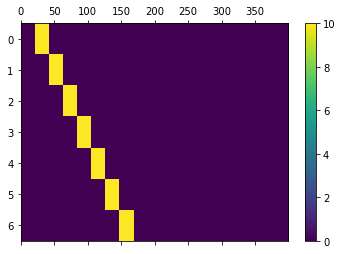

In [3]:
nz = 400
z_arr = np.linspace(0, 1.9, num=nz + 1)[1:]

nbins_T = z_obs.len() - 1

kernels_T = np.zeros((nbins_T, nz))
for i in range(nbins_T):
    zminbin = z_obs.get(i)
    zmaxbin = z_obs.get(i + 1)
    Dz = zmaxbin - zminbin

    for iz in range(nz):
        z = z_arr[iz]
        if (z > zminbin) and (z <= zmaxbin):
            kernels_T[i, iz] = 1 / Dz

fig = plt.figure()
ax = fig.add_subplot(111)

im = ax.matshow(kernels_T)
ax.set_aspect("auto")
plt.colorbar(im)
pass

In [4]:
NSIDE = 2 * 512
NPIX = hp.nside2npix(NSIDE)
m = np.zeros(hp.nside2npix(NSIDE))
pix_theta_ecl, pix_phi_ecl = hp.pix2ang(NSIDE, np.arange(NPIX))

# Guaranteed mask
mask1_guaranteed = np.zeros(NPIX)
mask2_guaranteed = np.zeros(NPIX)
mask3_guaranteed = np.zeros(NPIX)

mask1_guaranteed_condition = (
    (pix_phi_ecl > 3.0 * np.pi / 4.0)
    & (pix_phi_ecl < 13.0 * np.pi / 12.0)
    & (pix_theta_ecl < np.pi / 2.0 - 30.0 * np.pi / 180)
    & (pix_theta_ecl > np.pi / 2.0 - 80.0 * np.pi / 180)
)
mask2_guaranteed_condition = (
    (pix_phi_ecl > 11.0 * np.pi / 6.0)
    & (pix_theta_ecl < np.pi / 2.0 - 20.0 * np.pi / 180)
    & (pix_theta_ecl > np.pi / 2.0 - 40.0 * np.pi / 180)
)
mask3_guaranteed_condition = (
    (pix_phi_ecl < np.pi / 4.0)
    & (pix_theta_ecl < np.pi / 2.0 - 20.0 * np.pi / 180)
    & (pix_theta_ecl > np.pi / 2.0 - 40.0 * np.pi / 180)
)

mask1_guaranteed[mask1_guaranteed_condition] = 1
mask2_guaranteed[mask2_guaranteed_condition] = 1
mask3_guaranteed[mask3_guaranteed_condition] = 1

mask_guaranteed = mask1_guaranteed + mask2_guaranteed + mask3_guaranteed

# Total mask
mask1_full = np.zeros(NPIX)
mask2_full = np.zeros(NPIX)
mask3_full = np.zeros(NPIX)

mask1_full_condition = (
    (pix_phi_ecl > 2.0 * np.pi / 3.0)
    & (pix_phi_ecl < 3.0 * np.pi / 2.0)
    & (pix_theta_ecl < np.pi / 2.0 - 10.0 * np.pi / 180)
    & (pix_theta_ecl > np.pi / 2.0 - 80.0 * np.pi / 180)
)
mask2_full_condition = (
    (pix_phi_ecl > 11.0 * np.pi / 6.0)
    & (pix_theta_ecl < np.pi / 2.0)
    & (pix_theta_ecl > np.pi / 2.0 - 45.0 * np.pi / 180)
)
mask3_full_condition = (
    (pix_phi_ecl < np.pi / 4.0)
    & (pix_theta_ecl < np.pi / 2.0)
    & (pix_theta_ecl > np.pi / 2.0 - 45.0 * np.pi / 180)
)

mask1_full[mask1_full_condition] = 1
mask2_full[mask2_full_condition] = 1
mask3_full[mask3_full_condition] = 1

mask_full = mask1_full + mask2_full + mask3_full

`S matrices`

In [5]:
# Full sky
t0 = time.time()
S_lacasa = PySSC.Sij(z_arr, kernels_T, cosmo_Class=cosmo)
t1 = time.time()
print("Full sky time (seconds) = " + str(t1 - t0))

S_full = Ncm.Matrix.new(S_lacasa.shape[0], S_lacasa.shape[1])
for i in range(len(S_lacasa)):
    for j in range(len(S_lacasa[i])):
        S_full.set(i, j, S_lacasa[i][j])


# Partial-Sky guaranteed
t0 = time.time()
S_lacasa = PySSC.Sij_psky(z_arr, kernels_T, mask=mask_guaranteed, cosmo_Class=cosmo)
t1 = time.time()
print("Partial sky guaranteed time (seconds) = " + str(t1 - t0))

S_guaranteed = Ncm.Matrix.new(S_lacasa.shape[0], S_lacasa.shape[1])
for i in range(len(S_lacasa)):
    for j in range(len(S_lacasa[i])):
        S_guaranteed.set(i, j, S_lacasa[i][j])


# Partial-Sky maximal
t0 = time.time()
S_lacasa = PySSC.Sij_psky(z_arr, kernels_T, mask=mask_full, cosmo_Class=cosmo)
t1 = time.time()
print("Partial sky maximal time (seconds) = " + str(t1 - t0))

S_maximal = Ncm.Matrix.new(S_lacasa.shape[0], S_lacasa.shape[1])
for i in range(len(S_lacasa)):
    for j in range(len(S_lacasa[i])):
        S_maximal.set(i, j, S_lacasa[i][j])

Full sky time (seconds) = 0.5192742347717285
Partial sky guaranteed time (seconds) = 31.828978776931763
Partial sky maximal time (seconds) = 18.602723121643066


# Define proxy modelling

In [7]:
cluster_m = Nc.ClusterMassNodist(lnM_min=np.log(10) * 14.0, lnM_max=np.log(10) * 16 )
cluster_z = Nc.ClusterRedshiftNodist(z_min=0.0, z_max=2.0)

# Initialize the `ClusterAbundance` object

In [8]:
mulf = Nc.MultiplicityFuncTinker.new()
mulf.set_mdef(Nc.MultiplicityFuncMassDef.CRITICAL)
mulf.set_Delta(200.0)

hmf = Nc.HaloMassFunction.new(dist, psf, mulf)
hbias_Tinker = Nc.HaloBiasTinker.new(hmf)
cad = Nc.ClusterAbundance.new(hmf, hbias_Tinker)

# Data model

$f(x_i)$ for the Gaussian distribution $$-2\ln L = \sum_{ij}\left[(f(x_i) - y_i)C^{-1}_{ij}(f(x_j) - y_j)\right] + \dots$$

In [9]:
mset = Ncm.MSet.new_array([cosmo,cluster_m,cluster_z])


ncounts_gauss = Nc.DataClusterNCountsGauss.new(cad)
ncounts_gauss.set_size((z_obs.len()-1)*(lnM_obs.len()-1))
ncounts_gauss.set_init(True)
ncounts_gauss.set_fix_cov(False)
ncounts_gauss.use_norma(True)
ncounts_gauss.set_z_obs(z_obs)
ncounts_gauss.set_lnM_obs(lnM_obs)
rng = Ncm.RNG.seeded_new (None, 1423)
print(ncounts_gauss.get_fix_cov()) 

`No SSC`

In [10]:
print("No SSC")


guaranteed_area = 2959.1
cad.set_area(guaranteed_area * (np.pi / 180) ** 2)
ncounts_gauss.set_has_ssc(False)
ncounts_gauss.resample(mset, rng)
ncounts_gauss.peek_mean().log_vals("y: ", "% 22.15g", True)
ncounts_gauss.peek_cov().log_vals("cov: ", "% 22.15g")

dset = Ncm.Dataset.new()
dset.append_data(ncounts_gauss)


cosmo.props.Omegac_fit = True
cosmo.props.Omegab_fit = False
cosmo.props.w_fit = True
# cosmo.props.H0_fit = True
prim.props.ln10e10ASA_fit = True
mfunc_oa = Ncm.ObjArray.new()
mfunc_sigma8 = Ncm.MSetFuncList.new("NcHICosmo:sigma8", psf)
mfunc_oa.add(mfunc_sigma8)
print(mfunc_sigma8.eval0(mset))

mset.prepare_fparam_map()


lh = Ncm.Likelihood.new(dset)

fit = Ncm.Fit.new(
    Ncm.FitType.NLOPT, "ln-neldermead", lh, mset, Ncm.FitGradType.NUMDIFF_FORWARD
)

init_sampler = Ncm.MSetTransKernGauss.new(0)
init_sampler.set_mset(mset)
init_sampler.set_prior_from_mset()
init_sampler.set_cov_from_rescale(1.0)  # 1

sampler = "apes"

nwalkers = int(math.ceil(250))  # 500
ssize = 50000  # 1000000

walker = Ncm.FitESMCMCWalkerAPES.new(nwalkers, mset.fparams_len())

esmcmc = Ncm.FitESMCMC.new_funcs_array(
    fit, nwalkers, init_sampler, walker, Ncm.FitRunMsgs.SIMPLE, mfunc_oa
)

esmcmc.set_data_file("mcmc_nossc.fits")

esmcmc.set_nthreads(4)
t0 = time.time()
esmcmc.start_run()
esmcmc.run(ssize / nwalkers)
# esmcmc.run (10)
# esmcmc.run_lre (50, 1.0e-3)
esmcmc.end_run()
t1 = time.time()

esmcmc.mean_covar()
fit.log_covar()

print("Full sky maximal time (seconds) = " + str(t1 - t0))

ncounts_gauss.peek_mean().log_vals("y: ", "%.3f", True)
ncounts_gauss.peek_cov().cov_dup_cor().log_vals("cov:", "%.3f")


No SSC
y:       1404.48255872508       3188.88102091669       4912.77186908212       6414.27956847085       7190.94063418398       7419.31076141925       7193.34466231093
cov:        1451.02843028958                      0                      0                      0                      0                      0                      0
cov:                       0       3238.36909943311                      0                      0                      0                      0                      0
cov:                       0                      0       5025.38454524762                      0                      0                      0                      0
cov:                       0                      0                      0       6399.31040142008                      0                      0                      0
cov:                       0                      0                      0                      0       7185.56466373922                      0                  

In [ ]:
ntests = 100.0
mcat = fitmc.mcat

mcat.log_current_chain_stats()
mcat.calc_max_ess_time(ntests, Ncm.FitRunMsgs.FULL)
mcat.calc_heidel_diag(ntests, 0.0, Ncm.FitRunMsgs.FULL)

mset.pretty_log()
mcat.log_full_covar()
mcat.log_current_stats()

be, post_lnnorm_sd = mcat.get_post_lnnorm()
lnevol, glnvol = mcat.get_post_lnvol(0.6827)

Ncm.cfg_msg_sepa()
print(
    "# Bayesian evidence:                                 % 22.15g +/- % 22.15g"
    % (be, post_lnnorm_sd)
)
print("# 1 sigma posterior volume:                          % 22.15g" % lnevol)
print("# 1 sigma posterior volume (Gaussian approximation): % 22.15g" % glnvol)

# Creating the fit object and calculating the MCMC

`Full-Sky`

In [11]:
print("Full Sky")

guaranteed_area = 2959.1
cad.set_area(guaranteed_area * (np.pi / 180) ** 2)
ncounts_gauss.set_has_ssc(True)
ncounts_gauss.set_s_matrix(S_full)
ncounts_gauss.resample(mset, rng)
ncounts_gauss.peek_mean().log_vals("y: ", "% 22.15g", True)
ncounts_gauss.peek_cov().log_vals("cov: ", "% 22.15g")

dset = Ncm.Dataset.new()
dset.append_data(ncounts_gauss)


cosmo.props.Omegac_fit = True
cosmo.props.Omegab_fit = False
cosmo.props.w_fit = True
# cosmo.props.H0_fit = True
prim.props.ln10e10ASA_fit = True
mfunc_oa = Ncm.ObjArray.new()
mfunc_sigma8 = Ncm.MSetFuncList.new("NcHICosmo:sigma8", psf)
mfunc_oa.add(mfunc_sigma8)
print(mfunc_sigma8.eval0(mset))

mset.prepare_fparam_map()


lh = Ncm.Likelihood.new(dset)

fit = Ncm.Fit.new(
    Ncm.FitType.NLOPT, "ln-neldermead", lh, mset, Ncm.FitGradType.NUMDIFF_FORWARD
)

init_sampler = Ncm.MSetTransKernGauss.new(0)
init_sampler.set_mset(mset)
init_sampler.set_prior_from_mset()
init_sampler.set_cov_from_rescale(1.0)  # 1

sampler = "apes"

nwalkers = int(math.ceil(250))  # 500
ssize = 50000  # 1000000

walker = Ncm.FitESMCMCWalkerAPES.new(nwalkers, mset.fparams_len())

esmcmc = Ncm.FitESMCMC.new_funcs_array(
    fit, nwalkers, init_sampler, walker, Ncm.FitRunMsgs.SIMPLE, mfunc_oa
)

esmcmc.set_data_file("mcmc_fullsky.fits")

esmcmc.set_nthreads(4)
t0 = time.time()
esmcmc.start_run()
esmcmc.run(ssize / nwalkers)
# esmcmc.run (10)
# esmcmc.run_lre (50, 1.0e-3)
esmcmc.end_run()
t1 = time.time()

esmcmc.mean_covar()
fit.log_covar()

print("Full sky maximal time (seconds) = " + str(t1 - t0))

ncounts_gauss.peek_mean().log_vals("y: ", "%.3f", True)
ncounts_gauss.peek_cov().cov_dup_cor().log_vals("cov:", "%.3f")

Full Sky
y:       1383.78976605537       3182.06425163724       4959.83093722426       6480.25682212417       7342.81514287474       7543.25634654459       7457.76482903608
cov:        1712.05224052478      -109.040026318287      -37.0701599893422      -17.1963582842458      -9.65683209605913      -5.02771054297084      -2.35289460357991
cov:       -109.040026318287       3827.79186655443      -190.299788926372      -70.0673225982726      -30.1810884827129      -15.5602931944972      -8.29641655855135
cov:       -37.0701599893422      -190.299788926372       5944.30068211776      -242.686684708887      -93.1108243309707      -37.3231974738172       -18.966879845419
cov:       -17.1963582842458      -70.0673225982726      -242.686684708887       7547.81848277949      -272.077371881024      -101.505646338213      -40.2748095485146
cov:       -9.65683209605913      -30.1810884827129      -93.1108243309707      -272.077371881024       8427.98450971802      -258.132712525371      -99.739622

# NcmMSetCatalog: Current mean:   1.8198e+05   0.98         0.2512      -1.0313       3.2609     
# NcmMSetCatalog: Current msd:    27267        0.025233     0.00060214   0.00062109   0.048346   
# NcmMSetCatalog: Current sd:     4.3112e+05   0.39897      0.0095207    0.0098202    0.76441    
# NcmMSetCatalog: Current var:    1.8587e+11   0.15917      9.0643e-05   9.6437e-05   0.58432    
# NcmMSetCatalog: Current tau:    1            1            1            1            1          
# NcmMSetCatalog: Current skfac: -nan         -nan         -nan         -nan         -nan        
# NcmMSetCatalog: Maximal Shrink factor = 1e+10                 
#----------------------------------------------------------------------------------
# NcmMSetCatalog: Computing the constant break point for parameter `0', sample size `1':
# NcmMSetCatalog: Constant break point at `0':
# NcmFitESMCMC:last ensemble variance of -2ln(L):       186487411839.654 (2n = 6), min(-2ln(L)) =       91.1099561762219.
# Tas

In [ ]:
ntests = 100.0
mcat = fitmc.mcat

mcat.log_current_chain_stats()
mcat.calc_max_ess_time(ntests, Ncm.FitRunMsgs.FULL)
mcat.calc_heidel_diag(ntests, 0.0, Ncm.FitRunMsgs.FULL)

mset.pretty_log()
mcat.log_full_covar()
mcat.log_current_stats()

be, post_lnnorm_sd = mcat.get_post_lnnorm()
lnevol, glnvol = mcat.get_post_lnvol(0.6827)

Ncm.cfg_msg_sepa()
print(
    "# Bayesian evidence:                                 % 22.15g +/- % 22.15g"
    % (be, post_lnnorm_sd)
)
print("# 1 sigma posterior volume:                          % 22.15g" % lnevol)
print("# 1 sigma posterior volume (Gaussian approximation): % 22.15g" % glnvol)

`Partial-Sky guaranteed`

In [12]:
print("Partial sky guaranteed")

guaranteed_area = 2959.1
cad.set_area(guaranteed_area * (np.pi / 180) ** 2)
ncounts_gauss.set_has_ssc(True)
ncounts_gauss.set_s_matrix(S_guaranteed)
ncounts_gauss.resample(mset, rng)
ncounts_gauss.peek_mean().log_vals("y: ", "%.3f", True)


dset = Ncm.Dataset.new()
dset.append_data(ncounts_gauss)


cosmo.props.Omegac_fit = True
cosmo.props.Omegab_fit = False
cosmo.props.w_fit = True
# cosmo.props.H0_fit = True
prim.props.ln10e10ASA_fit = True
mfunc_oa = Ncm.ObjArray.new()
mfunc_sigma8 = Ncm.MSetFuncList.new("NcHICosmo:sigma8", psf)
mfunc_oa.add(mfunc_sigma8)
print(mfunc_sigma8.eval0(mset))

mset.prepare_fparam_map()


lh = Ncm.Likelihood.new(dset)

fit = Ncm.Fit.new(
    Ncm.FitType.NLOPT, "ln-neldermead", lh, mset, Ncm.FitGradType.NUMDIFF_FORWARD
)

init_sampler = Ncm.MSetTransKernGauss.new(0)
init_sampler.set_mset(mset)
init_sampler.set_prior_from_mset()
init_sampler.set_cov_from_rescale(1.0)  # 1


sampler = "apes"

nwalkers = int(math.ceil(500))  # 500
ssize = 50000  # 1000000

walker = Ncm.FitESMCMCWalkerAPES.new(nwalkers, mset.fparams_len())

esmcmc = Ncm.FitESMCMC.new_funcs_array(
    fit, nwalkers, init_sampler, walker, Ncm.FitRunMsgs.SIMPLE, mfunc_oa
)


esmcmc.set_data_file("mcmc_partialskyguaranteed.fits")

esmcmc.set_nthreads(4)
t0 = time.time()
esmcmc.start_run()
esmcmc.run(ssize / nwalkers)
# esmcmc.run (10)
# esmcmc.run_lre (50, 1.0e-3)
esmcmc.end_run()
t1 = time.time()

esmcmc.mean_covar()
fit.log_covar()

print("Full sky maximal time (seconds) = " + str(t1 - t0))

ncounts_gauss.peek_mean().log_vals("y: ", "%.3f", True)
ncounts_gauss.peek_cov().cov_dup_cor().log_vals("cov:", "%.3f")

Partial sky guaranteed
y: 1509.079 3288.184 4954.615 6591.852 7355.993 7858.876 7283.684
0.8460229555825772
#----------------------------------------------------------------------------------
# NcmFitESMCMC: Starting Ensemble Sampler Markov Chain Monte Carlo.
#   Number of walkers: 0500.
#   Number of threads: 0004.
#   Using MPI:         no - use MPI enabled but no slaves available.
# NcmFitESMCMC: No RNG was defined, using algorithm: `mt19937' and seed: 1852123781.


# NcmMSetCatalog: Current mean:   1.8058e+05   0.96984      0.24542     -1.0488       3.2777     
# NcmMSetCatalog: Current msd:    29362        0.016909     0.00042297   0.00045888   0.033231   
# NcmMSetCatalog: Current sd:     6.5656e+05   0.3781       0.0094579    0.010261     0.74306    
# NcmMSetCatalog: Current var:    4.3107e+11   0.14296      8.9452e-05   0.00010529   0.55214    
# NcmMSetCatalog: Current tau:    1            1            1            1            1          
# NcmMSetCatalog: Current skfac: -nan         -nan         -nan         -nan         -nan        
# NcmMSetCatalog: Maximal Shrink factor = 1e+10                 
#----------------------------------------------------------------------------------
# NcmMSetCatalog: Computing the constant break point for parameter `0', sample size `1':
# NcmMSetCatalog: Constant break point at `0':
# NcmFitESMCMC:last ensemble variance of -2ln(L):       431876680582.919 (2n = 6), min(-2ln(L)) =       87.4465356196819.
# Tas

In [ ]:
ntests = 100.0
mcat = fitmc.mcat

mcat.log_current_chain_stats()
mcat.calc_max_ess_time(ntests, Ncm.FitRunMsgs.FULL)
mcat.calc_heidel_diag(ntests, 0.0, Ncm.FitRunMsgs.FULL)

mset.pretty_log()
mcat.log_full_covar()
mcat.log_current_stats()

be, post_lnnorm_sd = mcat.get_post_lnnorm()
lnevol, glnvol = mcat.get_post_lnvol(0.6827)

Ncm.cfg_msg_sepa()
print(
    "# Bayesian evidence:                                 % 22.15g +/- % 22.15g"
    % (be, post_lnnorm_sd)
)
print("# 1 sigma posterior volume:                          % 22.15g" % lnevol)
print("# 1 sigma posterior volume (Gaussian approximation): % 22.15g" % glnvol)

`Partial Sky maximal`

In [13]:
print("Partial Sky maximal area")

maximal_area = 10009.97
cad.set_area(maximal_area * (np.pi / 180) ** 2)
ncounts_gauss.set_has_ssc(True)
ncounts_gauss.set_s_matrix(S_maximal)
ncounts_gauss.resample(mset, rng)
ncounts_gauss.peek_mean().log_vals("y: ", "%.3f", True)


dset = Ncm.Dataset.new()
dset.append_data(ncounts_gauss)


cosmo.props.Omegac_fit = True
cosmo.props.Omegab_fit = False
cosmo.props.w_fit = True
# cosmo.props.H0_fit = True
prim.props.ln10e10ASA_fit = True
mfunc_oa = Ncm.ObjArray.new()
mfunc_sigma8 = Ncm.MSetFuncList.new("NcHICosmo:sigma8", psf)
mfunc_oa.add(mfunc_sigma8)
print(mfunc_sigma8.eval0(mset))

mset.prepare_fparam_map()


lh = Ncm.Likelihood.new(dset)

fit = Ncm.Fit.new(
    Ncm.FitType.NLOPT, "ln-neldermead", lh, mset, Ncm.FitGradType.NUMDIFF_FORWARD
)

init_sampler = Ncm.MSetTransKernGauss.new(0)
init_sampler.set_mset(mset)
init_sampler.set_prior_from_mset()
init_sampler.set_cov_from_rescale(1.0)  # 1


sampler = "apes"

nwalkers = int(math.ceil(500))  # 500
ssize = 50000  # 1000000

walker = Ncm.FitESMCMCWalkerAPES.new(nwalkers, mset.fparams_len())

esmcmc = Ncm.FitESMCMC.new_funcs_array(
    fit, nwalkers, init_sampler, walker, Ncm.FitRunMsgs.SIMPLE, mfunc_oa
)


esmcmc.set_data_file("mcmc_partialskymaximal.fits")

esmcmc.set_nthreads(4)
t0 = time.time()
esmcmc.start_run()
esmcmc.run(ssize / nwalkers)
# esmcmc.run (10)
# esmcmc.run_lre (50, 1.0e-3)
esmcmc.end_run()
t1 = time.time()

esmcmc.mean_covar()
fit.log_covar()

print("Full sky maximal time (seconds) = " + str(t1 - t0))

ncounts_gauss.peek_mean().log_vals("y: ", "%.3f", True)
ncounts_gauss.peek_cov().cov_dup_cor().log_vals("cov:", "%.3f")

Partial Sky maximal area
y: 5060.925 11353.232 18004.716 23128.734 26571.227 26792.270 26644.403
0.848967708026005
#----------------------------------------------------------------------------------
# NcmFitESMCMC: Starting Ensemble Sampler Markov Chain Monte Carlo.
#   Number of walkers: 0500.
#   Number of threads: 0004.
#   Using MPI:         no - use MPI enabled but no slaves available.
# NcmFitESMCMC: No RNG was defined, using algorithm: `mt19937' and seed: 1464830483.


# NcmMSetCatalog: Current mean:   4.1505e+05   1.0083       0.25277     -1.0253       3.3353     
# NcmMSetCatalog: Current msd:    61669        0.016822     0.00042565   0.00045189   0.031801   
# NcmMSetCatalog: Current sd:     1.379e+06    0.37615      0.0095178    0.010105     0.71109    
# NcmMSetCatalog: Current var:    1.9015e+12   0.14149      9.0589e-05   0.0001021    0.50565    
# NcmMSetCatalog: Current tau:    1            1            1            1            1          
# NcmMSetCatalog: Current skfac: -nan         -nan         -nan         -nan         -nan        
# NcmMSetCatalog: Maximal Shrink factor = 1e+10                 
#----------------------------------------------------------------------------------
# NcmMSetCatalog: Computing the constant break point for parameter `0', sample size `1':
# NcmMSetCatalog: Constant break point at `0':
# NcmFitESMCMC:last ensemble variance of -2ln(L):       1905126779238.79 (2n = 6), min(-2ln(L)) =       100.175502946079.
# Tas

In [ ]:
ntests = 100.0
mcat = fitmc.mcat

mcat.log_current_chain_stats()
mcat.calc_max_ess_time(ntests, Ncm.FitRunMsgs.FULL)
mcat.calc_heidel_diag(ntests, 0.0, Ncm.FitRunMsgs.FULL)

mset.pretty_log()
mcat.log_full_covar()
mcat.log_current_stats()

be, post_lnnorm_sd = mcat.get_post_lnnorm()
lnevol, glnvol = mcat.get_post_lnvol(0.6827)

Ncm.cfg_msg_sepa()
print(
    "# Bayesian evidence:                                 % 22.15g +/- % 22.15g"
    % (be, post_lnnorm_sd)
)
print("# 1 sigma posterior volume:                          % 22.15g" % lnevol)
print("# 1 sigma posterior volume (Gaussian approximation): % 22.15g" % glnvol)